## 1. Get data ready

In [25]:
import torchvision
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer 

# Evaluation metrics
from torchmetrics import Accuracy

import matplotlib.pyplot as plt
import pandas as pd

In [26]:
# Define device
device = 'cpu'

# Define folder to save images
CNN_images_folder = './source_images/CNN'

# Download and save images
### The data comes in the following structure: image, target
train_data = torchvision.datasets.FashionMNIST(
    root=CNN_images_folder, 
    train=True,
    download=True,
    transform= torchvision.transforms.ToTensor())

test_data = torchvision.datasets.FashionMNIST(
    root=CNN_images_folder, 
    train=False,
    download=True,
    transform= torchvision.transforms.ToTensor())

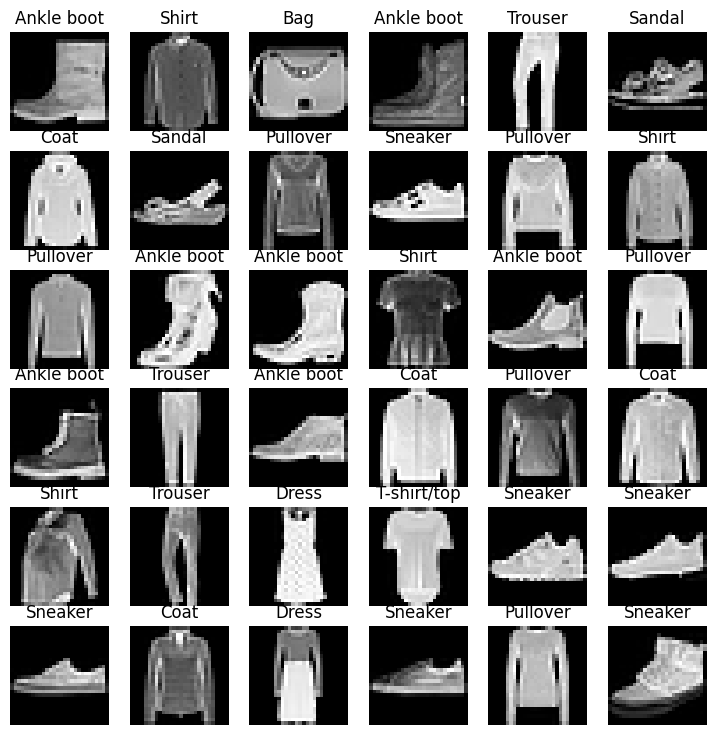

In [27]:
# Plot some examples
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 6,6
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis(False);

In [28]:
# Transform dataset from FashionMNIST to DataLoader with batches of 32 images for iteration purposes
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle= True,
                              collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle= True,
                              collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

## 2. Build model

In [29]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a sample
x, __ = train_data[0]

# Flatten the sample
output = flatten_model(x)

# Print output
print(f'Shape before flattening {x.shape} --> [Color channels, height, width]')
print(f'Shape after flattening {output.shape} --> [Color channels, height*width]')

Shape before flattening torch.Size([1, 28, 28]) --> [Color channels, height, width]
Shape after flattening torch.Size([1, 784]) --> [Color channels, height*width]


In [30]:
# Create baseline model
class FashionMNISTModelV0(nn.Module):
    # Constructor
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        # Define model
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # We send the images to a vector befor processing them into a model
            nn.Linear(in_features= input_shape, 
                      out_features= hidden_units),
            # nn.ReLU(),  --> For now not activation layers
            nn.Linear(in_features= hidden_units, 
                      out_features= output_shape),
        )
    # Create forward pass
    def forward(self, x):
        return self.layer_stack(x)

# Model parameters
IN_SHAPE = train_data[0][0].shape[1]*train_data[0][0].shape[2]
HIDD_UNITS = 10
OUT_SHAPE = len(train_data.classes)
    
# Instanciate model
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(
    input_shape= IN_SHAPE,
    hidden_units= HIDD_UNITS,
    output_shape= OUT_SHAPE 
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [31]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup Optimizer
optimizer = torch.optim.SGD(
    params = model_0.parameters(),
    lr = 0.1)

# Instanciate loss metrics
accuracy = Accuracy(task="multiclass", num_classes=OUT_SHAPE).to(device)

In [32]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

## 3. Train model

### 3.1 baseline NN model

In [33]:
%%time

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set number of epochs
epochs = 3

# Create training loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    # Training loss per batch
    train_loss = 0
    
    # Training model
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        # Forward propagation
        model_0.train()
        # 1. Forward pass
        train_pred = model_0(X_train)
        # 2. Calculate loss (per batch)
        loss = loss_fn(train_pred, y_train)
        train_loss += loss  # accumulatively add up the loss per epoch 

        # Backward propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X_train)}/{len(train_dataloader.dataset)} samples")

    # Divide train loss by total of batches
    train_loss /= len(train_dataloader)

    # Testing model
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:

            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y_test) # accumulatively add up the loss per epoch

             # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy(test_pred.argmax(dim=1), y_test)
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)
        test_acc *= 100

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]


Train loss: 0.59039 | Test loss: 0.51016, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:04<00:02,  2.02s/it]


Train loss: 0.47435 | Test loss: 0.52677, Test acc: 81.68%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Train loss: 0.45367 | Test loss: 0.51264, Test acc: 83.00%

Train time on cpu: 6.002 seconds
CPU times: user 5.75 s, sys: 857 ms, total: 6.61 s
Wall time: 6.01 s


In [34]:
def eval_model(
        model: nn.Module,
        test_dataloader: torch.utils.data.DataLoader,
        loss_fn: nn.Module,
        accuracy: Accuracy): 
    """ Method to evaluate model performance
    Args:
        model (nn.Module): Current model object
        test_dataloader (torch.utils.data.DataLoader): Iterable of the test set of images
        loss_fn (nn.Module): Model loss function
        accuracy (torchmetrics.Accuracy): Model accuracy function
    Return:
        Dictionary: Contains the results of the evaluation metrics
    """
    # Set seed
    torch.manual_seed(42)
    # Testing model
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in tqdm(test_dataloader):
            # Make predictions
            test_pred = model(X_test)

            # Accumulate metrics
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy(test_pred.argmax(dim=1), y_test)
        
        # Scale evaluation metrics
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    return {'model_name': model.__class__.__name__, # Only works when model was created with a class
            'model_loss': test_loss.item(),
            'model_acc': test_acc.item()}

In [35]:
# Calculate model_0 results
model_0_results = eval_model(
        model= model_0.to(device),
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

100%|██████████| 313/313 [00:00<00:00, 1100.20it/s]


### 3.2 Calibrated baseline NN model

In [36]:
# Define device
device = 'mps' if torch.has_mps else 'cpu'

# Create new model
class FashionMNISTModelV1(nn.Module):
    # Constructor
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        # Define model
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # We send the images to a vector befor processing them into a model
            nn.Linear(in_features= input_shape, 
                      out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, 
                      out_features= output_shape),
            nn.ReLU()
        )
    # Create forward pass
    def forward(self, x):
        return self.layer_stack(x)

# Instanciate model
model_1 = FashionMNISTModelV1(
                input_shape = IN_SHAPE,
                hidden_units= HIDD_UNITS,
                output_shape= OUT_SHAPE).to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup Optimizer
optimizer = torch.optim.SGD(
    params = model_1.parameters(),
    lr = 0.1)

# Instanciate loss metrics
accuracy = Accuracy(task="multiclass", num_classes=OUT_SHAPE).to(device)

### Setup helper functions for training

In [37]:
# Training helper function
def train_step(
    data_loader: DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy: Accuracy,
    device: torch.device = device):
    """ Performs training step on model trying to learn in data_loader"""
    # Training loss per batch
    train_loss, train_acc = 0, 0
    
    # Put model into training mode
    model.train()

    # Training model
    for batch, (X, y) in enumerate(data_loader):

        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward propagation
        train_pred = model(X)
        loss = loss_fn(train_pred, y)

        # Training metrics
        train_loss += loss
        train_acc += accuracy(train_pred.argmax(dim=1), y)

        # Backward propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Divide train loss by total of batches
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_acc *= 100
    print(f'Train_loss: {train_loss: .4f} | train_acc: {train_acc: .2f}%')

# Testing helper function
def test_step(
        data_loader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        accuracy: Accuracy,
        device: torch.device = device): 
    """ Performs testing step on model trying to evaluate in data_loader"""
    # Testing model
    test_loss, test_acc = 0, 0

    # Put model into evaluation mode
    model.eval()

    # Evaluate model
    with torch.inference_mode():
        for X, y in data_loader:

            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Make predictions
            test_pred = model(X)

            # Accumulate metrics
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy(test_pred.argmax(dim=1), y)
        
        # Scale evaluation metrics
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_acc *= 100
        print(f'Test_loss: {test_loss: .4f} | test_acc: {test_acc: .2f}%')

In [38]:
%%time
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set number of epochs
epochs = 3

# Create training loop
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")

    # Training function
    train_step(
        data_loader= train_dataloader,
        model= model_1,
        loss_fn= loss_fn,
        optimizer= optimizer,
        accuracy= accuracy)

    # Testing function
    test_step(
        data_loader= test_dataloader,
        model= model_1,
        loss_fn= loss_fn,
        accuracy= accuracy)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

Epoch: 0
-------
Train_loss:  0.6933 | train_acc:  75.74%
Test_loss:  0.5515 | test_acc:  80.59%
Epoch: 1
-------
Train_loss:  0.4959 | train_acc:  82.30%
Test_loss:  0.5709 | test_acc:  79.80%
Epoch: 2
-------
Train_loss:  0.4678 | train_acc:  83.29%
Test_loss:  0.5393 | test_acc:  81.67%
Train time on mps: 31.516 seconds
CPU times: user 19.6 s, sys: 2.39 s, total: 22 s
Wall time: 31.5 s


In [39]:
# Calculate model_1 results
model_1_results = eval_model(
        model= model_1,
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

100%|██████████| 313/313 [00:01<00:00, 228.42it/s]


> **Note:** The training time on GPU vs CPU will depend largely on the quality of the CPU/GPU you're using. Read on for a more explained answer.
>
> **Question:** "I used a a GPU but my model didn't train faster, why might that be?"
>
> **Answer:** Well, one reason could be because your dataset and model are both so small (like the dataset and model we're working with) the benefits of using a GPU are outweighed by the time it actually takes to transfer the data there.
> 
> There's a small bottleneck between copying data from the CPU memory (default) to the GPU memory.
>
> So for smaller models and datasets, the CPU might actually be the optimal place to compute on.
>
> But for larger datasets and models, the speed of computing the GPU can offer usually far outweighs the cost of getting the data there.
>
> However, this is largely dependant on the hardware you're using. With practice, you will get used to where the best place to train your models is. 

### 3.3 Building a Convolutional Neural Network (CNN)

In [40]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    Model from CNN explainer Website
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # Instanciate CNN
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape, 
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding= 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units, 
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding= 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units*7*7, # Number of channels in our images dataset
                      out_features= output_shape)
        )

    # Forward Step
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

#  Define Image channels
IM_CHANNELS = train_data[0][0].shape[0]

# Inicialize the model
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape= IM_CHANNELS, 
                              hidden_units= HIDD_UNITS, 
                              output_shape= OUT_SHAPE).to(device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [41]:
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [42]:
%%time
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set number of epochs
epochs = 3

# Create training loop
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")

    # Training function
    train_step(
        data_loader= train_dataloader,
        model= model_2,
        loss_fn= loss_fn,
        optimizer= optimizer,
        accuracy= accuracy)

    # Testing function
    test_step(
        data_loader= test_dataloader,
        model= model_2,
        loss_fn= loss_fn,
        accuracy= accuracy)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

Epoch: 0
-------
Train_loss:  0.5948 | train_acc:  78.32%
Test_loss:  0.4059 | test_acc:  85.34%
Epoch: 1
-------
Train_loss:  0.3582 | train_acc:  87.04%
Test_loss:  0.3833 | test_acc:  86.57%
Epoch: 2
-------
Train_loss:  0.3217 | train_acc:  88.42%
Test_loss:  0.3479 | test_acc:  87.86%
Train time on mps: 42.443 seconds
CPU times: user 28.7 s, sys: 3.73 s, total: 32.4 s
Wall time: 42.5 s


In [43]:
# Calculate model_2 results
model_2_results = eval_model(
        model= model_2.to(device),
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

100%|██████████| 313/313 [00:01<00:00, 198.08it/s]


### Model 3 - Best model

In [53]:
# Inicialize the model
torch.manual_seed(42)
model_3 = FashionMNISTModelV2(input_shape= IM_CHANNELS, 
                              hidden_units= HIDD_UNITS, 
                              output_shape= OUT_SHAPE).to(device)
# Optimizer
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

model_3

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [54]:
%%time
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set number of epochs
epochs = 10

# Create training loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    # Training function
    train_step(
        data_loader= train_dataloader,
        model= model_3,
        loss_fn= loss_fn,
        optimizer= optimizer,
        accuracy= accuracy)

    # Testing function
    test_step(
        data_loader= test_dataloader,
        model= model_3,
        loss_fn= loss_fn,
        accuracy= accuracy)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_3 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Train_loss:  0.5948 | train_acc:  78.32%


 10%|█         | 1/10 [00:14<02:08, 14.22s/it]

Test_loss:  0.4059 | test_acc:  85.34%
Epoch: 1
-------
Train_loss:  0.3582 | train_acc:  87.04%


 20%|██        | 2/10 [00:28<01:54, 14.32s/it]

Test_loss:  0.3833 | test_acc:  86.57%
Epoch: 2
-------
Train_loss:  0.3217 | train_acc:  88.42%


 30%|███       | 3/10 [00:42<01:40, 14.34s/it]

Test_loss:  0.3479 | test_acc:  87.86%
Epoch: 3
-------
Train_loss:  0.3002 | train_acc:  89.08%


 40%|████      | 4/10 [00:57<01:26, 14.38s/it]

Test_loss:  0.3100 | test_acc:  88.53%
Epoch: 4
-------
Train_loss:  0.2862 | train_acc:  89.56%


 50%|█████     | 5/10 [01:11<01:12, 14.42s/it]

Test_loss:  0.3180 | test_acc:  88.55%
Epoch: 5
-------
Train_loss:  0.2739 | train_acc:  89.99%


 60%|██████    | 6/10 [01:26<00:57, 14.35s/it]

Test_loss:  0.3018 | test_acc:  89.26%
Epoch: 6
-------
Train_loss:  0.2683 | train_acc:  90.30%


 70%|███████   | 7/10 [01:40<00:43, 14.35s/it]

Test_loss:  0.3132 | test_acc:  89.13%
Epoch: 7
-------
Train_loss:  0.2606 | train_acc:  90.65%


 80%|████████  | 8/10 [01:54<00:28, 14.34s/it]

Test_loss:  0.3106 | test_acc:  88.63%
Epoch: 8
-------
Train_loss:  0.2561 | train_acc:  90.71%


 90%|█████████ | 9/10 [02:09<00:14, 14.38s/it]

Test_loss:  0.2856 | test_acc:  89.72%
Epoch: 9
-------
Train_loss:  0.2506 | train_acc:  90.86%


100%|██████████| 10/10 [02:23<00:00, 14.34s/it]

Test_loss:  0.2839 | test_acc:  90.05%
Train time on mps: 143.387 seconds
CPU times: user 1min 35s, sys: 12 s, total: 1min 47s
Wall time: 2min 23s


In [55]:
# Calculate model_3 results
model_3_results = eval_model(
        model= model_3.to(device),
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

100%|██████████| 313/313 [00:01<00:00, 191.25it/s]


In [56]:
model_3_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2844724953174591,
 'model_acc': 0.9001597166061401}

<p> Compare results on models:</p>

In [57]:
compare_results = pd.DataFrame([
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results])

compare_results['Training_time'] = [round(total_train_time_model_0,2),
                                    round(total_train_time_model_1,2),
                                    round(total_train_time_model_2,2),
                                    round(total_train_time_model_3,2)]

compare_results

,model_name,model_loss,model_acc,Training_time
0,FashionMNISTModelV0,0.512530,0.830072,6.00
1,FashionMNISTModelV1,0.539148,0.816593,31.52
2,FashionMNISTModelV2,0.347899,0.878694,42.44
3,FashionMNISTModelV2,0.284472,0.900160,143.39


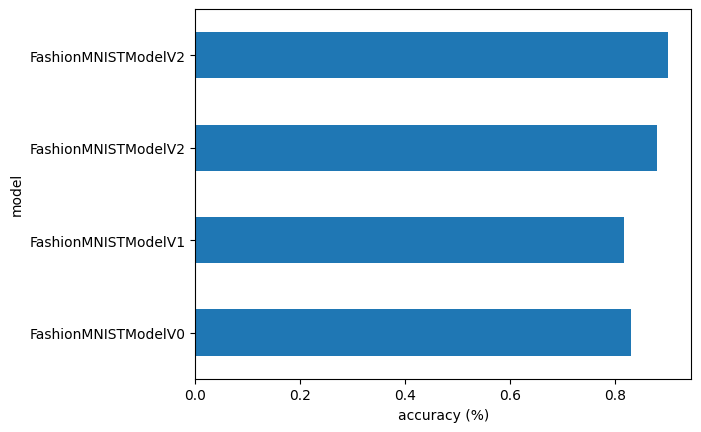

In [58]:
# Visualize model results
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model');

## 4. Make Predictions

In [59]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    # Set the model in evaluation mode
    model.eval()
    # Make predictions
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (Add a batch dim and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (get logits)
            pred_logit = model(sample)

            # Get pred probabilities
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Send predictions to CPU for further use
            pred_probs.append(pred_prob.cpu())
    # Stack pred_probs into a tensor and return
    return torch.stack(pred_probs)

In [101]:
#  Get random list of test samples
import random
# random.seed(42)
test_samples= []
test_labels= []

# Iterate test_data and extract random samples and labels
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

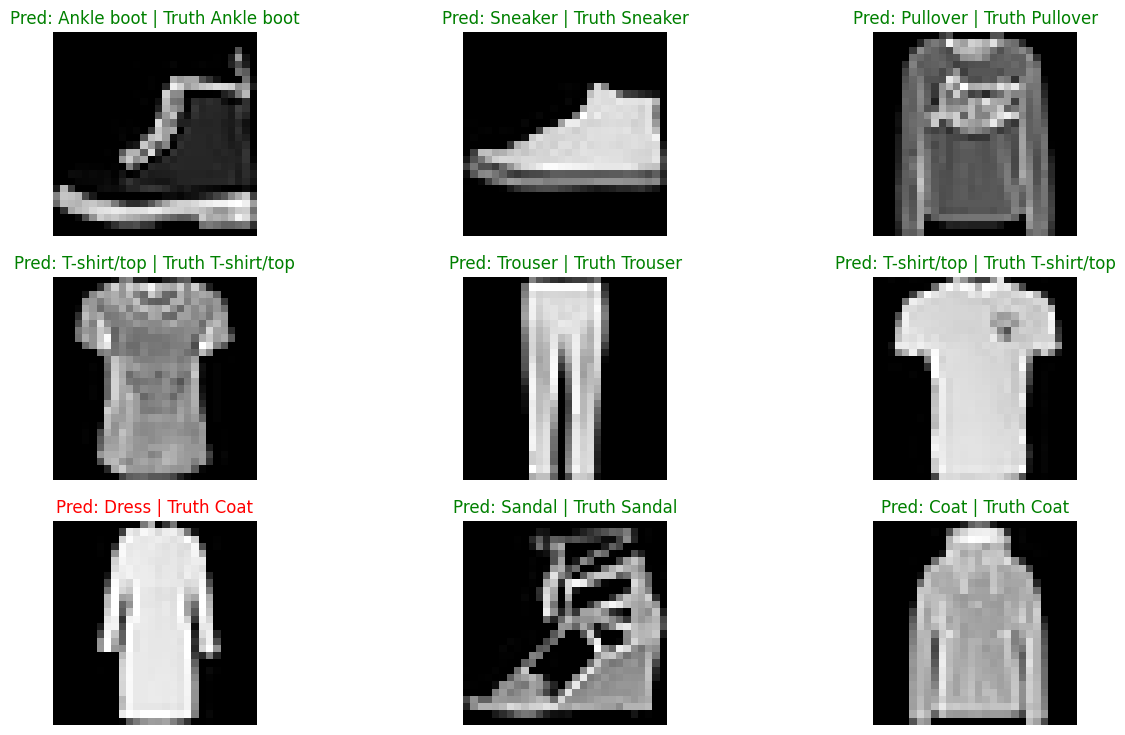

In [103]:
# Make predictions
pred_labels = make_predictions(model_3, test_samples).argmax(dim=1)

# Plot examples
fig = plt.figure(figsize=(15,9))
rows, cols = 3,3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(rows, cols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap='gray')

    # Find the prediction (Text)
    pred_label = test_data.classes[pred_labels[i]]

    # Get truth label (Text)
    truth_label = test_data.classes[test_labels[i]]

    # Plot title
    title_text = f"Pred: {pred_label} | Truth {truth_label}"

    # Check for eqality between pred and truth
    if pred_label == truth_label:
        plt.title(title_text, c='g')
    else:
        plt.title(title_text, c='r')

    plt.axis(False);